In [1]:
import csv
import pickle
import pathlib
import numpy as np
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from gensim.models import KeyedVectors

# Load aligned word2vec model
p = pathlib.Path("word2vec_model/")
wv_ptt = KeyedVectors.load(str(p / "ptt_aligned.model"), mmap='r')
wv_wei = KeyedVectors.load(str(p / "weibo_aligned.model"), mmap='r')

# Get collocations
left_collo = set()
right_collo = set()
with open("country_collocates.csv", newline='') as csvfile:
    rows = csv.DictReader(csvfile)
    for row in rows:
        if row["collo_pos"] == "left":
            left_collo.add(row["collo"])
        else:
            right_collo.add(row["collo"])
        if row["collo"] == '️': print(row)

with open(p / "common_vocab.pkl", "rb") as f:
    vocab = pickle.load(f)
vocab = list(left_collo.union(right_collo).intersection(vocab))
X = np.append(wv_ptt[vocab], wv_wei[vocab], axis=0)

100%|██████████| 38/38 [00:02<00:00, 13.82it/s]


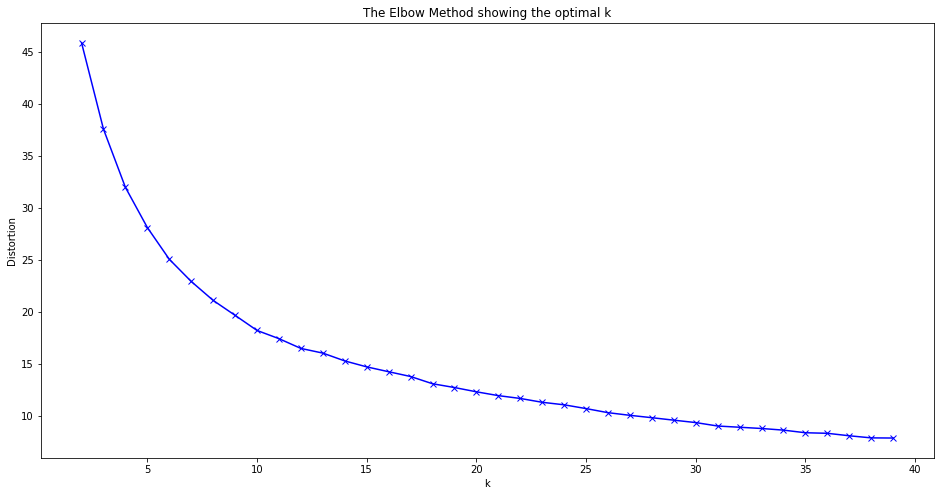

In [2]:
# PCA
X_pca = PCA().fit_transform(X)[:, :4]
distortions = []
K = list(range(2, 40))
for k in tqdm(K):
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X_pca)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


In [5]:
# Use 10 clusters
kmeanModel = KMeans(n_clusters=10)
kmeanModel.fit(X_pca)
labels = kmeanModel.predict(X_pca)
Counter(labels)

Counter({7: 38, 2: 42, 3: 44, 9: 26, 6: 39, 0: 33, 1: 46, 4: 32, 8: 32, 5: 52})

In [7]:
words = [(v, "ptt") for v in vocab] + [(v, "wei") for v in vocab]
results = sorted( ((w[0], w[1], l) for w, l in zip(words, labels)), key=lambda x: x[2] )
results

[('據', 'ptt', 0),
 ('年', 'ptt', 0),
 ('前', 'ptt', 0),
 ('者', 'ptt', 0),
 ('與', 'ptt', 0),
 ('為', 'ptt', 0),
 ('政治', 'ptt', 0),
 ('娛樂', 'ptt', 0),
 ('年', 'wei', 0),
 ('赴', 'wei', 0),
 ('獨立', 'wei', 0),
 ('指出', 'wei', 0),
 ('加入', 'wei', 0),
 ('向', 'wei', 0),
 ('在', 'wei', 0),
 ('前', 'wei', 0),
 ('從', 'wei', 0),
 ('第一', 'wei', 0),
 ('邀請', 'wei', 0),
 ('來到', 'wei', 0),
 ('開展', 'wei', 0),
 ('青年', 'wei', 0),
 ('者', 'wei', 0),
 ('出賣', 'wei', 0),
 ('進入', 'wei', 0),
 ('參加', 'wei', 0),
 ('與', 'wei', 0),
 ('參與', 'wei', 0),
 ('學生', 'wei', 0),
 ('早期', 'wei', 0),
 ('史', 'wei', 0),
 ('大會', 'wei', 0),
 ('代表', 'wei', 0),
 ('上空', 'ptt', 1),
 ('美食', 'ptt', 1),
 ('政壇', 'ptt', 1),
 ('玩弄', 'ptt', 1),
 ('協會', 'ptt', 1),
 ('豬肉', 'ptt', 1),
 ('留在', 'ptt', 1),
 ('移民', 'ptt', 1),
 ('邀請', 'ptt', 1),
 ('偶像', 'ptt', 1),
 ('工廠', 'ptt', 1),
 ('小學生', 'ptt', 1),
 ('購買', 'ptt', 1),
 ('逼近', 'ptt', 1),
 ('上映', 'ptt', 1),
 ('牌', 'ptt', 1),
 ('二十年', 'ptt', 1),
 ('出賣', 'ptt', 1),
 ('教書', 'ptt', 1),
 ('藝人', 'ptt', 1),
 ('萬一',

In [8]:
with open("cluster_labels.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["collocate", "src", "cluster"])
    writer.writerows(results)